## Introduction
In this notebook we will introduce 2D numerical models with heterogeneous conductivity fields. This will allow us to illustrate the difference between mechanical dispersion at the scale of an REV and the macrodispersion that results from heterogeneity. If you haven't installed go back to the FloPy Introduction notebook.

Import the standard libraries

In [3]:
# Import the flopy library
import flopy
# Import a few additional libraries
import sys
import os
import time
# In addition to our typical libraries
import numpy as np
import matplotlib.pyplot as plt

flopy is installed in C:\ProgramData\Anaconda3\lib\site-packages\flopy


First find where you have your MODFLOW and MT3D executables located on your system.

In [4]:
# Path to MODFLOW executable, probably called 'mf2005'
exe_name_mf = 'C:\\Hydro\\MF2005.1_12\\MF2005.1_12\\bin\\mf2005'
# Print to make sure it is formated correctly
print(exe_name_mf)
# Path to MT3D executable, probably called 'mt3dms'
exe_name_mt = 'C:\\Hydro\\mt3dusgs1.1.0\\mt3dusgs1.1.0\\bin\\mt3d-usgs_1.1.0_64'
# Print to make sure it is formated correctly
print(exe_name_mt)

C:\Hydro\MF2005.1_12\MF2005.1_12\bin\mf2005
C:\Hydro\mt3dusgs1.1.0\mt3dusgs1.1.0\bin\mt3d-usgs_1.1.0_64


Check these paths. Do they look correct for your system? If not this will lead to errors later.

Now lets name the folder(s) where we want will save our model.  

In [5]:
# This should return a path to your current working directory
current_directory = os.getcwd()
print(current_directory)

C:\Users\zahas\Dropbox\Teaching\Contaminant hydro 629\Modeling_excercises\Contaminant-Hydrogeology-Activities


In [6]:
# if this is not where you want to save stuff then change your directory using 'os.chdir()'
os.chdir('C:\\Users\\zahas\\Dropbox\\Teaching\\Contaminant hydro 629\\Modeling_excercises')
current_directory = os.getcwd()
print(current_directory)

C:\Users\zahas\Dropbox\Teaching\Contaminant hydro 629\Modeling_excercises


In [7]:
# now lets give a name to the directory to save data, this directory should be present in your 
# current working directory (but if it's not don't worry!)
directory_name = 'data_2D_model'
# Let's add that to the path of the current directory
workdir = os.path.join('.', directory_name)

# if the path exists then we will move on, if not then create a folder with the 'directory_name'
if os.path.isdir(workdir) is False:
    os.mkdir(workdir) 
print("Directory '% s' created" % workdir) 

Directory '.\data_2D_model' created


In [8]:
# specific folder name to save model data and output
dirname = 'BC_illustration'

Now let's assign this as our model workspace

In [9]:
# directory to save data
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')
# Model workspace and new sub-directory
model_ws = os.path.join(workdir, dirname)
print(model_ws)

.\data_2D_model\BC_illustration


Notice however that we don't yet name the folder where we will save data 'dirname'. This will be an input to our model function.

## 2D Heterogeneous Conductivity Field
In this notebook we want to model solute transport on a heterogeneous conductivity field. Make sure you have downloaded the text file 'anisotropic_perm_field_sig100000.csv'. 

## 2D Model Function with Homogeneous Conductivity Field
The first thing we do is setup the function. We will use nearly identical settings as the FloPy Introduction, but now we are providing a few input variables that can be changed everytime we call the model. The input variables are:

### Function Input:
#### directory name
    direname = 

    
#### dispersivity
Set the longitudinal dispersivity in selected units. What are the units again?

    al = 
    
#### itype
Itype is an integer indicating the type of solute source condition. itype = 1 is interpreted as the source concentration with the unit of mass per unit volume, which, when multiplied by its corresponding flow rate from the flow model, yields the mass-loading rate of the source. 2 = well, 3 = drain, -1 = constant concentration

    itype = 

In [198]:
def model_2D(dirname, al, itype):
    # Model workspace and new sub-directory
    model_ws = os.path.join(workdir, dirname)
    print(model_ws)
    
    # time units (itmuni in discretization package), unfortunately this entered differently into MODFLOW and MT3D
    # 1 = seconds, 2 = minutes, 3 = hours, 4 = days, 5 = years
    itmuni = 1 # MODFLOW
    mt_tunit = 'S' # MT3D units
    # length units (lenuniint in discretization package)
    # 0 = undefined, 1 = feet, 2 = meters, 3 = centimeters
    lenuni = 3 # MODFLOW units
    mt_lunit = 'CM' # MT3D units
    
    # NOTE: that the there are two additional columns added as dummy slices (representing coreholder faces)
    hk = hk_value*np.ones([1, hk_size[1], hk_size[2]])
    hk_size = hk.shape
    # determine dummy slice perm based on maximum hydraulic conductivity
    dummy_slice_hk = 100*hk.max()*np.ones([1, hk_size[1], 1])
    # define new conductivity field with dummy slices
    hk = np.concatenate((dummy_slice_hk, hk, dummy_slice_hk), axis=2)
    
    # number of stress periods (MF input), calculated from period length input
    nper = len(perlen_mf)
    
    # Frequency of output, If nprs > 0 results will be saved at 
    #     the times as specified in timprs; 
    nprs = 100
    # timprs (list of float): The total elapsed time at which the simulation 
    #     results are saved. The number of entries in timprs must equal nprs. (default is None).
    timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)
    
    # Model information 
    nlay = hk_size[0] # number of layers
    nrow = hk_size[1] # number of rows
    ncol = hk_size[2]+2 # number of columns (plus 2 for the dummy slices)
    delr = 0.25 # grid size in direction of Lx
    delc = 1.0 # grid size in direction of Ly, arbitrary
    delv = 0.25 # grid size in direction of Lz
    laytyp = 0
    
    # length of model in selected units 
    Lx = (ncol - 1) * delr
    print("Model length is: " + str(Lx + delr) + " (check units of 'lenuni')")
    
    # hydraulic conductivity
    geo_mean_k = np.exp(np.sum(np.log(hk))/hk.size)
    # advection velocity (function input)
    # v = 0.014
    # porosity
    prsity = 0.3
    # discharge (again in selected units)
    q = v * prsity
    
    # Flow field boundary conditions
    # MODFLOW head boundary conditions, <0 = specified head, 0 = no flow, >0 variable head
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    # index the inlet cells
    ibound[0, :, 0] = -1 # commented out because set with well
    # index the outlet cells 
    ibound[0, :, -1] = -1
    # constant head conditions
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    
    h1 = q * Lx/geo_mean_k
    # index the inlet cell
    strt[0, :, 0] = h1
    print("Inlet head value: " + str(h1) + " (check units of 'lenuni')")
    
    hout = 0
    strt[:, :, -1] = hout
    print("Outlet head value: " + str(hout) + " (check units of 'lenuni')")
    
    # Solute transport boundary conditions
    # Concentration at inlet boundary
    # Initial concentration (MT input)
    c0 = 1.
    # Stress period 2 concentration
    c1 = 0.0

    # Boundary conditions: if icbund = 0, the cell is an inactive concentration cell; 
    # If icbund < 0, the cell is a constant-concentration cell; 
    # If icbund > 0, the cell is an active concentration cell where the concentration value will be calculated.
    icbund = np.ones((nlay, nrow, ncol), dtype=np.int)
    icbund[0, :, 0] = -1 # constant-concentration cell

    # Initial conditions: concentration zero everywhere, except the inlet
    sconc = np.zeros((nlay, nrow, ncol), dtype=np.float)
    sconc[0, :, 0] = c0
    
    
    # Setup models
    # MODFLOW model name
    modelname_mf = dirname + '_mf'
    # MODFLOW package class
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    # MODFLOW model discretization package class
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    # MODFLOW basic package class
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    # MODFLOW layer properties flow package class
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    # MODFLOW preconditioned conjugate-gradient package class
    pcg = flopy.modflow.ModflowPcg(mf)
    # MODFLOW Link-MT3DMS Package Class (this is the package for solute transport)
    lmt = flopy.modflow.ModflowLmt(mf)
    
    mf.write_input()
    mf.run_model(silent=True) # Set this to false to produce output in command window
    
    # RUN MT3dms solute tranport 
    modelname_mt = dirname + '_mt'
    # MT3DMS Model Class
    # Input: modelname = 'string', namefile_ext = 'string' (Extension for the namefile (the default is 'nam'))
    # modflowmodelflopy.modflow.mf.Modflow = This is a flopy Modflow model object upon which this Mt3dms model is based. (the default is None)
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)  
    
    
    # Basic transport package class
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, 
                             tunit=mt_tunit, lunit=mt_lunit, nprs=nprs, timprs=timprs)
    
    # mixelm is an integer flag for the advection solution option, 
    # mixelm = 0 is the standard finite difference method with upstream or central in space weighting.
    # mixelm = 1 is the forward tracking method of characteristics, this seems to result in minimal numerical dispersion.
    # mixelm = 2 is the backward tracking
    # mixelm = 3 is the hybrid method
    # mixelm = -1 is the third-ord TVD scheme (ULTIMATE)
    mixelm = -1
    
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)
    
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
    ssm = flopy.mt3d.Mt3dSsm(mt)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    # Extract the output time information, convert from list to np array
    times = np.array(ucnobj.get_times())
    # Extract the 4D concentration values (t, x, y, z)
    conc = ucnobj.get_alldata()
    
    return mf, mt, times, conc

In [12]:
a = np.ones([2,4])
print(a)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]]


Let's also define a function for efficiently plotting the concentration fields

In [199]:
def plot_2d_conc(conc, x, y, times, time_step):
    fs =16 # fontsize
    fig2 = plt.figure(figsize=(10, 4)) # adjust these numbers to change the size of your figure
    ax = fig2.add_subplot(1, 1, 1, aspect='equal')
    # Use 'pcolor' function to plot 2d map of concentration
    imp = plt.pcolor(x, y, conc[time_step,0,:,:], cmap='OrRd', edgecolors='k', linewidths=0.2)
    # color limit range from 0 to 1
    plt.clim(0,1)
    # add a colorbar
    cbar = plt.colorbar() 
    # label the colorbar
    cbar.set_label('Solute concentration', fontsize=fs)
    # make colorbar font bigger
    cbar.ax.tick_params(labelsize= (fs-2)) 
    # make axis fontsize bigger!
    plt.tick_params(axis='both', which='major', labelsize=fs)
    # Label x-axis
    plt.xlabel('Distance from inlet [cm]', fontsize=fs)
    # add smart title
    plt.title('Time: %1.1f min' %(times[time_step]/60), fontsize=fs+2)

Ok, now we are ready to run some models! Let's first run the model with the weakly anisotropic permeability field.

In [200]:
hk_hom = np.array([0.00053]) #cm/sec

# Directory name
dirname = 'homogeneous_2D'
# Length of model run
perlen_mf = [60*60] 
v = 0.01
al = 1.0 # cm
# RUN model!
mf, mt, times, conc = model_2D(dirname, perlen_mf, hk_hom, v, al, nrow, ncol)

.\data_2D_model\homogeneous_2D
Model length is: 10.0 (check units of 'lenuni')
Inlet head value: 55.188679245283 (check units of 'lenuni')


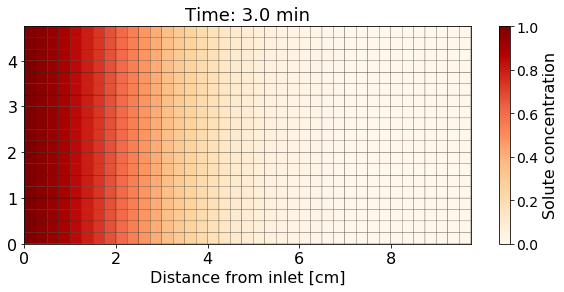

In [201]:
# Now let's call our plotting function
plot_2d_conc(conc, x, y, times, 5)

In [202]:
# Directory name
dirname = 'anisotropic_weak'
# RUN!
mf, mt, times_w, conc_weak = model_2D(dirname, perlen_mf, hk_weak, v, al, nrow, ncol)

.\data_2D_model\anisotropic_weak
Model length is: 10.0 (check units of 'lenuni')
Inlet head value: 54.04438360720681 (check units of 'lenuni')


Up to now, we have only seen 1D models. We call these 1D models because they vary in only one spatial dimension so the other two dimensions have a size of 1. Let's double check that the dimensions of this model are 2D. That means we expect a time dimension euqal to the variable 'nprs' + 1 from our FloPy function, 1 layer, and what are the lengths of the other two dimensions?

In [203]:
# Let's check your answer
np.shape(conc_weak)

(101, 1, 20, 40)

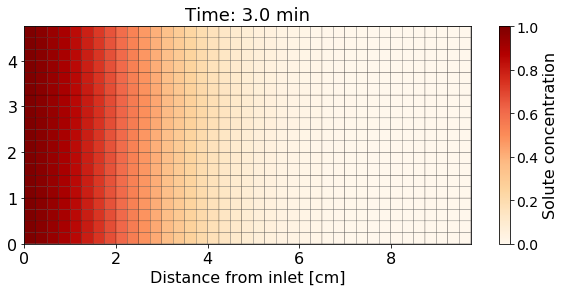

In [204]:
# Now let's call our plotting function
plot_2d_conc(conc_weak, x, y, times_w, 5)

Now let's run the identical model, the only difference is the permeability field anisotropy is 100x stronger.

In [205]:
mf, mt, times_s, conc_strong = model_2D(dirname, perlen_mf, hk_strong, v, al, nrow, ncol)

.\data_2D_model\anisotropic_weak
Model length is: 10.0 (check units of 'lenuni')
Inlet head value: 40.687843609043746 (check units of 'lenuni')


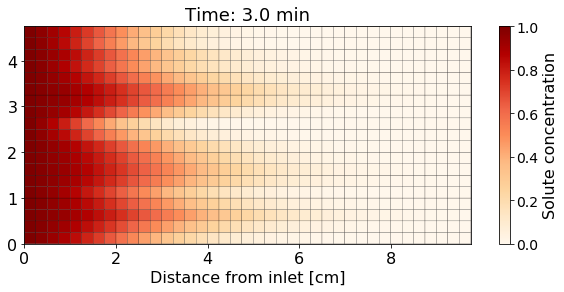

In [206]:
# Call our plotting function again
plot_2d_conc(conc_strong, x, y, times_s, 5)

Explain what is going on here.

In [207]:
# Remember that we need a few special functions
from scipy.special import erfc as erfc
from scipy.special import erf as erf

# Type 1 inlet conditions
def analytical_model_1D_t1(x, t, v, al):
    # Dispersion
    D = v*al
    # Analytical solution: See lecture slides or (Parker and van Genuchten, 1984) for details
    # Note that the '\' means continued on the next line
    Conc_time_type1 = (1/2)*erfc((x - v*t)/(2*np.sqrt(D*t))) + \
        (1/2)*np.exp(v*x/D)*erfc((x + v*t)/(2*np.sqrt(D*t)))
    
    return Conc_time_type1

# Type 3 inlet conditions
def analytical_model_1D_t3(x, t, v, al):
    # Dispersion
    D = v*al
    # Analytical solution: See lecture slides or (Parker and van Genuchten, 1984 eq 9b) for details
    Conc_time_type3 = (1/2)* erfc((x - v*t)/(2* np.sqrt(D*t))) + \
    np.sqrt((v**2*t)/(3.1415*D))* np.exp(-(x - v*t)**2/(4*D*t)) - \
    (1/2)*(1 + (v*x/D) + (v**2*t/D))* np.exp(v*x/D)* erfc((x + v*t)/(2* np.sqrt(D*t)))
    
    return Conc_time_type3

In [208]:
x = mf.dis.sr.xcenter
# Call the analytical model functions
Conc_time_type1_t = analytical_model_1D_t1(x[-1], times, v, al)
Conc_time_type3_t = analytical_model_1D_t3(x[-1], times, v, al)

In [209]:
# Extract the breakthrough time at the outlet
C_btc_h = np.mean([conc[:, 0, :, -1]], axis=2)
C_btc_w = np.mean([conc_weak[:, 0, :, -1]], axis=2)
C_btc_s = np.mean([conc_strong[:, 0, :, -1]], axis=2)



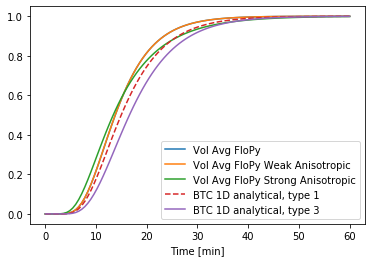

In [210]:
c1, = plt.plot(times/60, np.transpose(C_btc_h), label='Vol Avg FloPy')
c2, = plt.plot(times_w/60, np.transpose(C_btc_w), label='Vol Avg FloPy Weak Anisotropic')
c3, = plt.plot(times_s/60, np.transpose(C_btc_s), label='Vol Avg FloPy Strong Anisotropic')
c4, = plt.plot(times/60, Conc_time_type1_t, '--', label='BTC 1D analytical, type 1')
c5, = plt.plot(times/60, Conc_time_type3_t, label='BTC 1D analytical, type 3')
plt.xlabel('Time [min]');

plt.legend(handles=[c1, c2, c3, c4, c5])

Model time: 6.0 min
(1, 40)


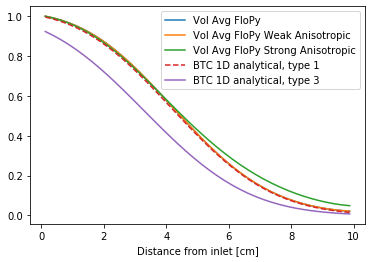

In [211]:
# Ploc concentration profiles
# Choose a timestep to evaluate the analytical solution at
timestep = 10
# Note that this timestep corresponds to the numerical model output increment, the actual model time is given by
print('Model time: ' + str(times[timestep]/60) + ' min')

C_profile_h = np.mean([conc[timestep, 0, :, :]], axis=1)
C_profile_w = np.mean([conc_weak[timestep, 0, :, :]], axis=1)
C_profile_s = np.mean([conc_strong[timestep, 0, :, :]], axis=1)

print(np.shape(C_profile_h))

# Call the analytical model functions
Conc_time_type1_x = analytical_model_1D_t1(x, times[timestep], v, al)
Conc_time_type3_x = analytical_model_1D_t3(x, times[timestep], v, al)

c1, = plt.plot(x, np.transpose(C_profile_h), label='Vol Avg FloPy')
c2, = plt.plot(x, np.transpose(C_profile_w), label='Vol Avg FloPy Weak Anisotropic')
c3, = plt.plot(x, np.transpose(C_profile_s), label='Vol Avg FloPy Strong Anisotropic')
c4, = plt.plot(x, Conc_time_type1_x, '--', label='BTC 1D analytical, type 1')
c5, = plt.plot(x, Conc_time_type3_x, label='BTC 1D analytical, type 3')
plt.xlabel('Distance from inlet [cm]')

plt.legend(handles=[c1, c2, c3, c4, c5])